In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import sys
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, concatenate, Dense, Flatten, Activation, Conv2DTranspose, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.optimizers import Adam,SGD
from keras.metrics import MeanIoU, Precision, Recall,Accuracy,BinaryAccuracy
from keras.losses import  BinaryFocalCrossentropy, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
print(tf.__version__)
print(sys.version)
filepath_4 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\image\\'
filepath_5 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\label\\'
filepath_6 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\val\\image\\'
filepath_7 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\val\\label\\'

def data_frame_num():
    #data_frame = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1.csv', header = None)
    data_frame = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\concatenated_folder_1_folder_2.csv', header = None)
    data_frame = data_frame.iloc[:,2:]
    print(data_frame.shape)
    return data_frame
data_frame = data_frame_num()
print(data_frame)
print(np.shape(data_frame)) 

input_x = tf.convert_to_tensor(data_frame) 
input_x.shape 
scaling = MinMaxScaler()
input_x_normal = pd.DataFrame(scaling.fit_transform(data_frame), columns = data_frame.columns)
print((input_x_normal))
# print((input_x_normal))
input_x = tf.convert_to_tensor(input_x_normal.values.reshape((-1,1,1,12))) 
print(input_x.shape[0])
print(type(input_x))

input_x = np.tile(input_x, [1,16,16,1]).astype('float32')


###2nd for val_numerical_data read from another csv made
def data_frame_num_val():  
    data_frame_val = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1_validation.csv', header = None)
    data_frame_val = data_frame_val.iloc[:,2:]
    return data_frame_val
    
data_frame_val = data_frame_num_val()     ##### (26,5)  (rows,columns)
print(np.shape(data_frame_val)) 
input_x_val = tf.convert_to_tensor(data_frame_val) 
input_x_val.shape 
scaling = MinMaxScaler()
input_x_normal_val = pd.DataFrame(scaling.fit_transform(data_frame_val), columns = data_frame_val.columns)
print((input_x_normal_val))
# print((input_x_normal))
input_x_val_num = tf.convert_to_tensor(input_x_normal_val.values.reshape((-1,1,1,12))) 
print(input_x_val_num.shape[0])
input_x_val_num = np.tile(input_x_val_num, [1,16,16,1]).astype('float32')

print(input_x_val_num.shape, 'Validation values reshaped to pixel wise which is at the bottom neck layer')


# def num_generator():
#     for t in data_frame.values:
#         yield t
#train_num = tf.data.Dataset.from_generator(input_x, output_signature =tf.TensorSpec(shape=(14,), dtype=tf.float32)).batch(5)

tf.random.set_seed(42)
train_num_1 = tf.data.Dataset.from_tensor_slices(input_x).batch(2).repeat(20)
print(np.shape(train_num_1))
print(len(train_num_1))
#print(train_num)
train_num_1_ = next(iter(train_num_1))
input_num_2 = train_num_1_.numpy().astype('float32') 
print(input_num_2.shape)

val_num_1 = tf.data.Dataset.from_tensor_slices(input_x_val_num).batch(2).repeat(20)
print(np.shape(val_num_1))
print(type(val_num_1))
train_val_1_ = next(iter(val_num_1))
input_val_2 = train_val_1_.numpy().astype('float32')
print(type(input_val_2))
print(input_val_2.shape)

#data_generation = ImageDataGenerator(rescale= 1.0/255)
#data_generation_1 = ImageDataGenerator(rescale= 1.0/255)
data_generation = ImageDataGenerator(rescale= 1.0/255,width_shift_range = 0.1, 
                                     height_shift_range = 0.1,
                                     shear_range =0.2, zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode =  'nearest')
# #data_generation_1 = ImageDataGenerator(rescale= 1.0/255,width_shift_range = 0.1, 
#                                      height_shift_range = 0.1,
#                                      shear_range =0.2, zoom_range = 0.2,
#                                      horizontal_flip = True,
#                                      fill_mode =  'nearest')
   
training_image = data_generation.flow_from_directory(filepath_4,
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)
training_mask = data_generation.flow_from_directory(filepath_5, 
                                                         
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42) 

validation_image = data_generation.flow_from_directory(filepath_6,
                                                         
                                                        target_size =(256,256),
                                                         batch_size = 1,class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)        
    #seed of both the directories should be same.

validation_mask = data_generation.flow_from_directory(filepath_7, 
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42)



# combination_training =zip(training_image,train_num_1,training_mask)
# combination_validation = zip(validation_image,val_num_1,validation_mask)
x = []
for z in range(158):
    train_im = next(iter(training_image)).astype('float32')
    x.append(train_im[0])
print(train_im.shape)
x_mask = []
for f in range(158):
    train_mas = next(iter(training_mask)).astype('float32')
    x_mask.append(train_mas[0])
print(train_mas.shape)

y = []
for d in range(10):
    val_im = next(iter(validation_image)).astype('float32')
    y.append(val_im[0])
print(val_im.shape)

y_mask = []
for r in range(10):
    val_mas = next(iter(validation_mask)).astype('float32')
    y_mask.append(val_mas[0])

print(val_mas.shape)

tf.random.set_seed(42)
x = np.array(x)

####Figure Plotting
# train_data = tf.data.Dataset.from_tensor_slices((x,x_mask)).take(1)
# # figure,ax = plt.subplots(2,2,figsize = (10,10))
# for image_train,image_mask in (train_data):
#     figure = plt.figure()
#     im = image_train
#     ax = figure.add_subplot(1,2,1)
#     ax.imshow(im, cmap = 'gray')
#     plt.title('train_set_image')
#     mas = image_mask
#     ax1 = figure.add_subplot(1,2,2)
#     ax1.imshow(mas, cmap = 'gray')
#     plt.title('train_set_mask')

# validation = tf.data.Dataset.from_tensor_slices((y,y_mask)).take(1)
# for y,y_mask in (validation):
#     figure = plt.figure()
#     im = y
#     ax = figure.add_subplot(1,2,1)
#     ax.imshow(im, cmap = 'gray')
#     plt.title('val_set_image')
#     mas = y_mask
#     ax1 = figure.add_subplot(1,2,2)
#     ax1.imshow(mas, cmap = 'gray')
#     plt.title('val_set_mask')
    

####zipping the files for training and validation for model.fit
x_train = tf.data.Dataset.from_tensor_slices((x,input_x)).batch(3).repeat(50)
#print(len(x_train))
print(type(x_train))
x_mask = np.array(x_mask)
x_mask_train = tf.data.Dataset.from_tensor_slices(x_mask).batch(3).repeat(50)
#print(len(x_mask_train))
data = tf.data.Dataset.zip((x_train,x_mask_train))
print(data.element_spec)


y = np.array(y)
y_val = tf.data.Dataset.from_tensor_slices((y, input_x_val_num)).batch(3).repeat(50)
#print(len(y_val))
y_mask = np.array(y_mask)
y_mask_val = tf.data.Dataset.from_tensor_slices(y_mask).batch(3).repeat(50)
#print(len(y_mask_val))
data_2 = tf.data.Dataset.zip((y_val,y_mask_val))
print(data_2.element_spec)

####Model Architechture
def convolutional(input_shape, filters):    #add BAtchnormalisation, think about it  in original paper it is not there.
    
    convolutional_block = Conv2D(filters = filters, kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal')(input_shape) #Functional API'S
    
    convolutional_block_1 = BatchNormalization()(convolutional_block)
    
    convolutional_block = Conv2D(filters = filters ,kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal')(convolutional_block_1)   #check which more kernel initializer we can add together using list
  
    return convolutional_block

def expansion(input_1,input_2,filters):
    
    conv_up_sample = Conv2DTranspose(filters = filters, kernel_size = (2,2), strides = (2,2),padding = 'same')(input_1)
    print(conv_up_sample)
    
    addition = concatenate([conv_up_sample, input_2]) # check here the input_2's size
    print(addition)
    
    addition = convolutional(addition,filters)
    
    return addition

input_shape_1 = (256, 256, 3)
input_num_1 = (16,16,12)


def densenet201(input_shape_1,input_num_1):
    input_shape = Input(input_shape_1)
    input_num = Input(input_num_1)
    skip = DenseNet201(include_top = False, weights = 'imagenet', input_tensor = input_shape)
    skip.summary()#only Convolutional Layers/Think that should we need classifier layers or not????
    #Skip Connections are skipped from the max_ool therefore the input size/2 and it will takes place 4 times for the contraction_unit.
    
    skip_1 = skip.get_layer('input_1').output 
    print(np.shape(skip_1))
    
    skip_2 = skip.get_layer('conv1/relu').output  
    print(np.shape(skip_2))                                         
    
    skip_3 = skip.get_layer('pool2_relu').output  
    print(np.shape(skip_3)) 
                                 
    
    skip_4 = skip.get_layer('pool3_relu').output                                     
    print(np.shape(skip_4))
    
    
    bottle_neck = skip.get_layer('pool4_relu').output  
    print(np.shape(bottle_neck),'bottle_neck_layer_shape')
    
    # print(bottle_layer_5, 'bottle layer value : ')
    # print(bottle_layer_5.shape, 'bottle_layer_5_shape')
    
    features = Flatten()(bottle_neck)
    
    print(features.shape, 'features_shape')
    
    input_expansion_2 = Flatten()(tf.reshape(input_num,[-1,16,16,12]))      #check should we reshape into batch_size 32*32*5 this is due to we are adding this in thebottle neck layer at the last axis or batch_size*1*5
    print(input_expansion_2.shape, ' Input_expansion_2')
    
    feature = concatenate([features,input_expansion_2], axis = -1)
    print(feature, 'features_bottle_layer_z')
    
    feature_1 = tf.reshape(feature, [-1,16,16,1804]) ##### 1792+14
    print(feature_1)
  
    
    
    up_sample_it_1 = expansion(feature_1, skip_4,1804)    ## write bottle_neck=feature_1 512,256,128,64 #1804//2//4//8//16
    print(np.shape(up_sample_it_1), 'Up_samle_1')
    
    up_sample_it_2 = expansion(up_sample_it_1,skip_3,1804//2)
    print(np.shape(up_sample_it_2), 'Up_samle_2')
    
    up_sample_it_3 = expansion(up_sample_it_2, skip_2,1804//4)
    print(np.shape(up_sample_it_3), 'Up_samle_3')
    
    up_sample_it_4 = expansion(up_sample_it_3, skip_1,1804//8)
    print(np.shape(up_sample_it_4), 'Up_samle_4')
    
    
    convolutional_block_1 = Conv2D(filters = 1806//16 ,kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'glorot_uniform') (up_sample_it_4)
    convolutional_block_2 = Conv2D(filters = 1806//32 ,kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'glorot_uniform') (convolutional_block_1)
    convolutional_block_3 = Conv2D(filters = 1806//64 ,kernel_size = 1, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'glorot_uniform') (convolutional_block_2)
    
    Conv_2 = Conv2D(1, kernel_size =1,activation = 'sigmoid', padding  = 'same')(convolutional_block_3) # classes = 2 segmented glass or not......
    
    #model = Model(inputs = input_shape , outputs = Conv_2)
    model = Model(inputs =[input_shape, input_num] , outputs = Conv_2)
    
    return model



densenet_201_and_U_NET =  densenet201(input_shape_1,input_num_1)  
densenet_201_and_U_NET.summary() 
print(densenet_201_and_U_NET.inputs)
  

def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient
    return dice_loss

def dice_metric(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient


#densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.0001), loss = ['binary_crossentropy',dice_loss], metrics=[Accuracy,Precision,Recall,MeanIoU(num_classes = 2)])
#densenet_201_and_U_NET.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss = dice_loss, metrics=BinaryIoU([0,1], threshold = 0.3))
#densenet_201_and_U_NET.compile(optimizer = 'adam', loss = BinaryFocalCrossentropy(gamma = 3), metrics =[dice_metric])
#densenet_201_and_U_NET.compile(optimizer = 'rmsprop', loss = dice_loss, metrics=[Precision(),Recall(),MeanIoU(num_classes = 2)])

# #densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.001), 
#                                loss = BinaryFocalCrossentropy(alpha= 0.25,gamma = 1), 
#                                metrics=[Precision(),Recall(),MeanIoU(num_classes = 2)])
# densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.0001), 
#                                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
#                                metrics=[Precision(),Recall(),MeanIoU(num_classes = 2)])
# densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.0001), 
#                                loss = [tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                                         BinaryFocalCrossentropy(alpha= 0.25,gamma = 2),dice_loss], 
#                                metrics=[Precision(),Recall(),MeanIoU(num_classes = 2)])
densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.0002), 
                               loss =dice_loss, 
                               metrics=[BinaryAccuracy(threshold=0.5),Precision(),Recall(),MeanIoU(num_classes = 2)])
# densenet_201_and_U_NET.compile(optimizer = 'rmsprop', 
#                                loss =dice_loss, 
#                                metrics=[BinaryAccuracy(threshold=0.5),Precision(),Recall(),MeanIoU(num_classes = 2)])
# densenet_201_and_U_NET.compile(optimizer = SGD(lr = 0.005, momentum = 0.95), 
#                                loss =dice_loss, 
#                                metrics=[BinaryAccuracy(threshold=0.5),Precision(),Recall(),MeanIoU(num_classes = 2)])



checkpoint = ModelCheckpoint('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_23.h5', verbose = 1, save_best_only = True)
#callbacks = [EarlyStopping(patience = 10, monitor = 'val_accuracy')]
#callbacks = [EarlyStopping(patience = 10, monitor = 'val_mean_io_u'), checkpoint]
callbacks = [EarlyStopping(patience = 10, monitor = 'val_mean_io_u'), checkpoint]
#callbacks = [EarlyStopping(patience = 10, monitor = 'dice_metric_val'), checkpoint]



# print(len(training_image))
# print(len(validation_image))

#history_unet = densenet_201_and_U_NET.fit(data,verbose = 1,validation_data =data_2, callbacks = callbacks,epochs = 50)
history_unet = densenet_201_and_U_NET.fit(data,steps_per_epoch = 30, verbose = 1,validation_data =data_2, callbacks = callbacks,validation_steps = 2, epochs = 50)
#history_unet = densenet_201_and_U_NET.fit((x_train,train_num_1),x_mask_train,steps_per_epoch = 46, verbose = 1,validation_data = ([y_val,val_num_1],y_mask_val), callbacks = callbacks, epochs = 20)
#history_unet = densenet_201_and_U_NET.fit([train_im,input_num_2],train_mas,steps_per_epoch = 19, verbose = 1, callbacks = callbacks, epochs = 20)
#history_unet = densenet_201_and_U_NET.fit([x,input_num_2],x_mask,steps_per_epoch=47,  verbose = 1, callbacks = callbacks, validation_data =([y,input_val_2],y_mask) ,validation_steps = 5, epochs = 20)
#history_unet = densenet_201_and_U_NET.fit([training_x_2, input_x_numerical_2],training_mask_2, steps_per_epoch = 9,  verbose = 1, callbacks = callbacks, validation_data = ([x_val_train_2,input_num_val_2],x_val_mask_2), epochs = 10)
#history_unet = model.fit(training_x,training_mask,steps_per_epoch =20, verbose = 1, callbacks = callbacks , validation_data =(x_val_train, x_val_mask), validation_steps = 2, epochs = 50)
#history_unet = densenet_201_and_U_NET.fit([training_image, input_x_numerical] ,training_mask,steps_per_epoch =training_image.samples//5, verbose = 1, callbacks = callbacks , validation_data =([validation_image,input_num_val], validation_mask), validation_steps = validation_image.samples//5, epochs = 10,batch_size = 5)
#history_unet = densenet_201_and_U_NET.fit([training_x, input_x_numerical] ,training_mask,steps_per_epoch =training_image.samples//5, verbose = 1, callbacks = callbacks , validation_data =([training_x_val,input_num_val], training_x_val_mask), validation_steps = validation_image.samples//5, epochs = 10)
#history_unet = densenet_201_and_U_NET.fit([training_image, input_x_numerical],training_mask,steps_per_epoch = 19, verbose = 1, callbacks = callbacks , validation_data =([validation_image,input_num_val], validation_mask), epochs = 10) 
#history_unet = densenet_201_and_U_NET.fit([np.array([training_x]), input_x_numerical],np.array([training_mask]), verbose = 1, callbacks = callbacks , validation_data =([np.array([x_val_train]),input_num_val],np.array([x_val_mask])), epochs = 100)   
#history_unet = densenet_201_and_U_NET.fit([training_x, input_x_numerical],training_mask,steps_per_epoch = 50, verbose = 1, callbacks = callbacks , validation_data =([validation_image,input_num_val], training_x_val_mask), validation_steps = 3, epochs = 50)
## see here how to add the input numerical data for fitiing
print(history_unet.history.keys())

losses = history_unet.history['loss']
validation_losses = history_unet.history['val_loss']
#epoch = (1, len(losses))
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, losses,'y', label = 'train_loss')
plt.plot(epochs, validation_losses, 'b', label = 'val_loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

mean_iou = history_unet.history['mean_io_u']
val_mean_iou = history_unet.history['val_mean_io_u']
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, mean_iou,'y', label = 'mean_iou_')
plt.plot(epochs, val_mean_iou, 'b', label = 'val_mean_iou_')
plt.title('mean iou and Val iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend()
plt.show()

In [6]:
##think from which layer to fine tune

for layer in densenet_201_and_U_NET.layers[180:]:
    layer.trainable = True
    
    
#densenet_201_and_U_NET.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
#densenet_201_and_U_NET.compile(optimizer = 'adam', loss = BinaryFocalCrossentropy(gamma = 2), metrics = MeanIoU(num_classes = 2))
#densenet_201_and_U_NET.compile(optimizer = 'adam', loss =  dice_loss, metrics=MeanIoU(num_classes = 2))
densenet_201_and_U_NET.compile(optimizer = Adam(lr = 0.0001), loss = dice_loss, metrics=[BinaryAccuracy(threshold=0.5),Precision(),Recall(),MeanIoU(num_classes = 2)])
#densenet_201_and_U_NET.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss = dice_loss, metrics=BinaryIoU([0,1], threshold = 0.3))
#densenet_201_and_U_NET.compile(optimizer = 'adam', loss = BinaryFocalCrossentropy(gamma = 3), metrics =[dice_metric])

densenet_201_and_U_NET.summary()

checkpoint = ModelCheckpoint('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_25.h5', verbose = 1, save_best_only = True)
#callbacks = [EarlyStopping(patience = 10, monitor = 'val_accuracy')]
#callbacks = [EarlyStopping(patience = 10, monitor = 'val_mean_io_u'), checkpoint]
callbacks = [EarlyStopping(patience = 10, monitor = 'val_mean_io_u_1'), checkpoint]

print(len(training_image))
print(len(validation_image))
history_unet = densenet_201_and_U_NET.fit(data, steps_per_epoch = 15,  verbose = 1, callbacks = callbacks, validation_data = data_2,  validation_steps = 2, epochs = 20)
#history_unet = model.fit(training_x,training_mask,steps_per_epoch =20, verbose = 1, callbacks = callbacks , validation_data =(x_val_train, x_val_mask), validation_steps = 2, epochs = 50)
## see here how to add the input numerical data for fitiing

#
losses = history_unet.history['loss']
validation_losses = history_unet.history['val_loss']
#epoch = (1, len(losses))
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, losses,'y', label = 'train_loss')
plt.plot(epochs, validation_losses, 'b', label = 'val_loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

mean_iou = history_unet.history['mean_io_u_3']
val_mean_iou = history_unet.history['val_mean_io_u_3']
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, mean_iou,'y', label = 'mean_iou_')
plt.plot(epochs, val_mean_iou, 'b', label = 'val_mean_iou_')
plt.title('mean iou and Val iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend()
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

KeyboardInterrupt: 

     0     1    2   3         4       5        6          7         8      9    
0   214  1100  150  45  212.0000 -0.5000   0.0625  47.399102  9.268593  4.288  \
1   215  1100  150  60  211.8750 -0.5625  14.6875  47.399102  9.268593  4.288   
2   234  1100  150  45  212.3125 -0.4375   0.1875  47.399102  9.268593  4.288   
3   235  1100  150  60  212.2500 -0.4375  14.8125  47.399102  9.268593  4.288   
4   254  1100  150  45  212.6875 -1.8750   0.3750  47.399102  9.268593  4.287   
5   255  1100  150  60  212.4375 -1.8750  15.0000  47.399102  9.268593  4.287   
6   274  1100  150  45  212.6875  0.0625   0.3125  47.399102  9.268593  4.287   
7   275  1100  150  60  212.6875  0.0625  15.1250  47.399102  9.268593  4.287   
8   294  1100  150  45  212.5625  0.1875   0.1875  47.399102  9.268593  4.288   
9   295  1100  150  60  212.5625  0.1875  14.8750  47.399102  9.268593  4.288   
10  314  1100  150  45  213.0625  0.1250   0.0000  47.399102  9.268593  4.287   
11  315  1100  150  60  213.

<Figure size 640x480 with 0 Axes>

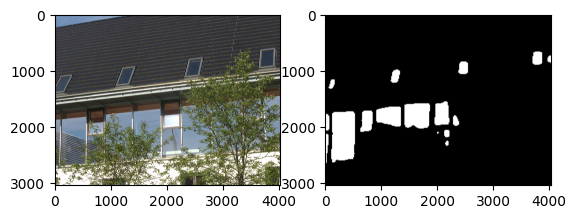

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import cv2
import tensorflow as tf
import keras.utils
from keras.models import load_model
import keras.losses
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#Define the custom loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = keras.backend.sum(y_true * y_pred)
    union = keras.backend.sum(y_true) + keras.backend.sum(y_pred)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coef

# Register the custom loss function
keras.losses.dice_loss = dice_loss

# Load the pretrained model with custom loss function
# with keras.utils.custom_object_scope({'dice_loss': dice_loss}):
#     model = load_model('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_3.h5')
    
with keras.utils.custom_object_scope({'dice_loss': dice_loss}):
    model = load_model('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_24.h5')   #22

# Preprocess the image
def preprocess_image(image):
    image = cv2.resize(image, (256, 256))  # Adjust input_width and input_height to match your model
    image = image / 255.0  # Normalize pixel values to the range of 0 to 1
    return image

def preprocess_numbers():
    data_frame_1 = pd.read_csv('C:\\Users\\Shah\\Desktop\\labelme\\labelme-main\\examples\\semantic_segmentation\\data_not_to_be_used _folder_2_18_may\\discarded_test.csv',header = None)
    data_frame_test_1 = data_frame_1.iloc[5,2:]
    data_frame_test_1 = np.reshape(data_frame_test_1,(1,12))
    return data_frame_1,data_frame_test_1
data_frame_1,data_frame_test_1 = preprocess_numbers() 
print(data_frame_1)##### (26,5)  (rows,columns)
print(np.shape(data_frame_1)) 
print(data_frame_test_1)##### (26,5)  (rows,columns)
print(np.shape(data_frame_test_1)) 

input_x_test = tf.convert_to_tensor(data_frame_test_1) 
input_x_test.shape 

scaling = MinMaxScaler()
input_x_normal_test = pd.DataFrame(scaling.fit_transform(input_x_test))  ###columns = data_frame_1.iloc[3].values
print((input_x_normal_test.shape))
print((input_x_normal_test))
input_x_num = tf.convert_to_tensor(input_x_normal_test.values.reshape((-1,1,1,12))) 
print(input_x_num.shape)
input_num_test = np.tile(input_x_num, [1,16,16,1]).astype('float32')
print(input_num_test.shape)
    

# # Load and preprocess the image
#image_path = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\image\\train_image\\POS_063.bmp'
# image_path = 'C:\\phtos (copy)\\2023031100080064\\POS_108.bmp'
image_path = 'C:\\Users\\Shah\\Desktop\\labelme\\labelme-main\\examples\\semantic_segmentation\\data_not_to_be_used _folder_2_18_may\\POS_055.bmp'
#image_path = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Images Windows trial\\images\\20230427_151934.jpg'
image = cv2.imread(image_path)
#print(image.shape)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im = cv2.imwrite('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\test.jpg', image)
im_1 = cv2.imread('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\test.jpg')
print(im_1.shape)

preprocessed_image = preprocess_image(im_1)
print(preprocessed_image.shape)

# # Reshape the image to match the input shape expected by the model
input_image = np.expand_dims(preprocessed_image, axis=0)
print(input_image.shape)
print(input_num_test.shape)
# input_test = np.expand_dims(input_num_test, axis=0)
# print(input_image.shape)

inputs = [input_image,input_num_test]
# # Run the inference
predicted_masks = model.predict(inputs)
print(predicted_masks.shape)

# plt.imshow(predicted_masks[0],cmap = 'gray')

# Postprocess the mask
threshold = 0.5  # Adjust this threshold based on your model's characteristics
predicted_masks = (predicted_masks > threshold).astype(np.uint8)
#plt.imshow(predicted_masks[0])

# # # Visualize the mask
mask = predicted_masks[0] * 255
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
figure = plt.figure()
im = cv2.resize(im_1, (image.shape[1], image.shape[0]))
ax = figure.add_subplot(1,2,1)
ax.imshow(im, cmap = 'gray')

mas = mask
ax1 = figure.add_subplot(1,2,2)
ax1.imshow(mask, cmap = 'gray')
plt.figure('random_sets_test')

# # # mask = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Resize mask to match original image dimensions
# # # masked_image = cv2.bitwise_and(image, image, mask=mask)

# # # # Display the original image and the masked image
# # # cv2.imshow('Original Image', image)
# # # cv2.imshow('Masked Image', masked_image)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()


In [142]:
###for loop testing data


import numpy as np
import cv2
import tensorflow as tf
import keras.utils
from keras.models import load_model
import keras.losses
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#Define the custom loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = keras.backend.sum(y_true * y_pred)
    union = keras.backend.sum(y_true) + keras.backend.sum(y_pred)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coef

# Register the custom loss function
keras.losses.dice_loss = dice_loss

# Load the pretrained model with custom loss function
# with keras.utils.custom_object_scope({'dice_loss': dice_loss}):
#     model = load_model('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_3.h5')
    
with keras.utils.custom_object_scope({'dice_loss': dice_loss}):
    model = load_model('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\model_u_net_21.h5')   #22

# Preprocess the image
def preprocess_image(image):
    image = cv2.resize(image, (256, 256))  # Adjust input_width and input_height to match your model
    image = image / 255.0  # Normalize pixel values to the range of 0 to 1
    return image

values = []
def preprocess_numbers():
    data_frame_1 = pd.read_csv('C:\\Users\\Shah\\Desktop\\labelme\\labelme-main\\examples\\semantic_segmentation\\data_not_to_be_used _folder_2_18_may\\discarded_test.csv',header = None)
    # for i,data in data_frame_1.iterrows():
    #     value = data.values
    #     values.append(value)
    return data_frame_1    
        #data_frame_test_1 = data_frame_1.iloc[i]
        #data_frame_test_1 = np.reshape(data_frame_test_1,(1,14))
        #return data_frame_1,data_frame_test_1
data_frame_1= preprocess_numbers() 
print(values)
print(np.shape(values))
 

input_x_normal_test = pd.DataFrame(data_frame_1)
print(input_x_normal_test)

scaling = MinMaxScaler()
input_x_normal_test= pd.DataFrame(scaling.fit_transform(input_x_normal_test))
print(input_x_normal_test)

input_x_num = tf.convert_to_tensor(input_x_normal_test.values.reshape((-1,1,1,14))) 
print(input_x_num.shape)
input_num_test = np.tile(input_x_num, [16,16,1]).astype('float32')
print(input_num_test.shape)
print(type(input_num_test))
print((input_num_test[0]).shape)

    
       
# #      print(k)

# Load and preprocess the image
# image_path = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\image\\train_image\\POS_063.bmp'
# image_path = 'C:\\phtos (copy)\\2023031100080064\\POS_108.bmp'
image_path = glob.glob('C:\\Users\\Shah\\Desktop\\labelme\\labelme-main\\examples\\semantic_segmentation\\data_not_to_be_used _folder_2_18_may\\*.bmp')
for u in image_path:

#image_path = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Images Windows trial\\images\\20230427_151934.jpg'
    image = cv2.imread(u)
#print(image.shape)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im = cv2.imwrite('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\test.jpg', image)
    im_1 = cv2.imread('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\test.jpg')
    print(im_1.shape)

    preprocessed_image = preprocess_image(im_1)
    print(preprocessed_image.shape)

# # Reshape the image to match the input shape expected by the model
    input_image = np.expand_dims(preprocessed_image, axis=0)
    print(input_image.shape)
    print(input_num_test.shape)
# input_test = np.expand_dims(input_num_test, axis=0)
# print(input_test.shape)

# inputs = [input_image,input_num_test[0]]
# print(inputs)
# # # Run the inference
# predicted_masks = model.predict(inputs)
# print(predicted_masks.shape)

# # plt.imshow(predicted_masks[0],cmap = 'gray')

# # Postprocess the mask
# threshold = 0.5  # Adjust this threshold based on your model's characteristics
# predicted_masks = (predicted_masks > threshold).astype(np.uint8)
# #plt.imshow(predicted_masks[0])

# # # # Visualize the mask
# mask = predicted_masks[0] * 255
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
# figure = plt.figure()
# im = cv2.resize(im_1, (image.shape[1], image.shape[0]))
# ax = figure.add_subplot(1,2,1)
# ax.imshow(im, cmap = 'gray')

# mas = mask
# ax1 = figure.add_subplot(1,2,2)
# ax1.imshow(mask, cmap = 'gray')
# plt.figure('random_sets_test')

# # # mask = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Resize mask to match original image dimensions
# # # masked_image = cv2.bitwise_and(image, image, mask=mask)

# # # # Display the original image and the masked image
# # # cv2.imshow('Original Image', image)
# # # cv2.imshow('Masked Image', masked_image)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()


[]
(0,)
     0     1    2   3         4       5        6          7         8      9    
0   214  1100  150  45  212.0000 -0.5000   0.0625  47.399102  9.268593  4.288  \
1   215  1100  150  60  211.8750 -0.5625  14.6875  47.399102  9.268593  4.288   
2   234  1100  150  45  212.3125 -0.4375   0.1875  47.399102  9.268593  4.288   
3   235  1100  150  60  212.2500 -0.4375  14.8125  47.399102  9.268593  4.288   
4   254  1100  150  45  212.6875 -1.8750   0.3750  47.399102  9.268593  4.287   
5   255  1100  150  60  212.4375 -1.8750  15.0000  47.399102  9.268593  4.287   
6   274  1100  150  45  212.6875  0.0625   0.3125  47.399102  9.268593  4.287   
7   275  1100  150  60  212.6875  0.0625  15.1250  47.399102  9.268593  4.287   
8   294  1100  150  45  212.5625  0.1875   0.1875  47.399102  9.268593  4.288   
9   295  1100  150  60  212.5625  0.1875  14.8750  47.399102  9.268593  4.288   
10  314  1100  150  45  213.0625  0.1250   0.0000  47.399102  9.268593  4.287   
11  315  1100  150  

In [19]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import sys
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, concatenate, Dense, Flatten, Activation, Conv2DTranspose, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.optimizers import Adam
from keras.metrics import MeanIoU, Precision, Recall,Accuracy
from keras.losses import  BinaryFocalCrossentropy, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
print(tf.__version__)
print(sys.version)
filepath_4 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\image\\'
filepath_5 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\train\\label\\'
filepath_6 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\val\\image\\'
filepath_7 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\trail_membrane\\val\\label\\'

def data_frame_num():
    data_frame = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1.csv', header = None)
    data_frame = data_frame.iloc[:,:]
    print(data_frame.shape)
    return data_frame
data_frame = data_frame_num()
print(data_frame)

print(np.shape(data_frame)) 
input_x = tf.convert_to_tensor(data_frame) 
input_x.shape 
scaling = MinMaxScaler()
input_x_normal = pd.DataFrame(scaling.fit_transform(data_frame), columns = data_frame.columns)
print((input_x_normal))
# print((input_x_normal))
input_x = tf.convert_to_tensor(input_x_normal.values.reshape((-1,1,1,14))) 
print(input_x.shape[0])
print(type(input_x))

input_x = np.tile(input_x, [1,16,16,1]).astype('float32')


###2nd for val_numerical_data read from another csv made
def data_frame_num_val():  
    data_frame_val = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1_validation.csv', header = None)
    data_frame_val = data_frame_val.iloc[:,:]
    return data_frame_val
    
data_frame_val = data_frame_num_val()     ##### (26,5)  (rows,columns)
print(np.shape(data_frame_val)) 
input_x_val = tf.convert_to_tensor(data_frame_val) 
input_x_val.shape 
scaling = MinMaxScaler()
input_x_normal_val = pd.DataFrame(scaling.fit_transform(data_frame_val), columns = data_frame_val.columns)
print((input_x_normal_val))
# print((input_x_normal))
input_x_val_num = tf.convert_to_tensor(input_x_normal_val.values.reshape((-1,1,1,14))) 
print(input_x_val_num.shape[0])
input_x_val_num = np.tile(input_x_val_num, [1,16,16,1]).astype('float32')

print(input_x_val_num.shape, 'Validation values reshaped to pixel wise which is at the bottom neck layer')


# def num_generator():
#     for t in data_frame.values:
#         yield t
#train_num = tf.data.Dataset.from_generator(input_x, output_signature =tf.TensorSpec(shape=(14,), dtype=tf.float32)).batch(5)

tf.random.set_seed(42)
train_num_1 = tf.data.Dataset.from_tensor_slices(input_x).batch(2).repeat(20)
print(np.shape(train_num_1))
print(len(train_num_1))
#print(train_num)
train_num_1_ = next(iter(train_num_1))
input_num_2 = train_num_1_.numpy().astype('float32') 
print(input_num_2.shape)

val_num_1 = tf.data.Dataset.from_tensor_slices(input_x_val_num).batch(2).repeat(20)
print(np.shape(val_num_1))
print(type(val_num_1))
train_val_1_ = next(iter(val_num_1))
input_val_2 = train_val_1_.numpy().astype('float32')
print(type(input_val_2))
print(input_val_2.shape)

#data_generation = ImageDataGenerator(rescale= 1.0/255)
#data_generation_1 = ImageDataGenerator(rescale= 1.0/255)
data_generation = ImageDataGenerator(rescale= 1.0/255,width_shift_range = 0.1, 
                                     height_shift_range = 0.1,
                                     shear_range =0.2, zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode =  'nearest')
# #data_generation_1 = ImageDataGenerator(rescale= 1.0/255,width_shift_range = 0.1, 
#                                      height_shift_range = 0.1,
#                                      shear_range =0.2, zoom_range = 0.2,
#                                      horizontal_flip = True,
#                                      fill_mode =  'nearest')
   
training_image = data_generation.flow_from_directory(filepath_4,
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)
training_mask = data_generation.flow_from_directory(filepath_5, 
                                                         
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42) 

validation_image = data_generation.flow_from_directory(filepath_6,
                                                         
                                                        target_size =(256,256),
                                                         batch_size = 1,class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)        
    #seed of both the directories should be same.

validation_mask = data_generation.flow_from_directory(filepath_7, 
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42)

# combination_training = tf.data.Dataset.from_generator(lambda: zip(training_image,train_num_1,training_mask),output_signature = (tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Images
#     tf.TensorSpec(shape=(None,16,16,14), dtype=tf.float32),  # Labels
#     tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32) ))
# combination_validation = tf.data.Dataset.from_generator(lambda : zip(validation_image,val_num_1,validation_mask),output_signature = (tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Images
#     tf.TensorSpec(shape=(None,16,16,14), dtype=tf.float32),  # Labels
#     tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32)) )

# combination_training =zip(training_image,train_num_1,training_mask)
# combination_validation = zip(validation_image,val_num_1,validation_mask)




x = []
for z in range(95):
    train_im = next(iter(training_image)).astype('float32')
    x.append(train_im[0])
print(train_im.shape)
print(np.shape(x))

x_mask = []
for f in range(95):
    train_mas = next(iter(training_mask)).astype('float32')
    x_mask.append(train_mas[0])
print(train_mas.shape)
print(np.shape(x_mask))

y = []
for d in range(10):
    val_im = next(iter(validation_image)).astype('float32')
    y.append(val_im[0])
print(val_im.shape)
print(np.shape(y))

y_mask = []
for r in range(10):
    val_mas = next(iter(validation_mask)).astype('float32')
    y_mask.append(val_mas[0])
print(val_mas.shape)
print(np.shape(y_mask))

tf.random.set_seed(42)
x = np.array(x)

x_train = tf.data.Dataset.from_tensor_slices((x,input_x)).batch(2).repeat(50)
list(x_train.as_numpy_iterator())
print(len(x_train))
print(type(x_train))

x_mask = np.array(x_mask)
x_mask_train = tf.data.Dataset.from_tensor_slices(x_mask).batch(2).repeat(50)
print(len(x_mask_train))

data = tf.data.Dataset.zip((x_train,x_mask_train))
print(data.element_spec)

y = np.array(y)
y_val = tf.data.Dataset.from_tensor_slices((y, input_x_val_num)).batch(2).repeat(50)
# for i,j in y_val:
#     print(len(i),len(j))
print(len(y_val))

y_mask = np.array(y_mask)
y_mask_val = tf.data.Dataset.from_tensor_slices(y_mask).batch(2).repeat(50)
print(len(y_mask_val))

data_2 = tf.data.Dataset.zip((y_val,y_mask_val))
print(data_2.element_spec)

# for (item,item_1),item_2 in (data_2):
#      print(np.shape(item),np.shape(item_1),np.shape(item_2))

2.12.0
3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
(95, 14)
     0     1    2   3         4       5        6        7         8      9    
0   200  1100   10  45  158.1875  1.3125   6.9375  47.3991  9.268559  4.288  \
1   201  1100   10  60  158.3125  1.1250  21.9375  47.3991  9.268559  4.288   
2   202  1100   30  45  138.5625 -0.5625   7.0625  47.3991  9.268559  4.288   
3   203  1100   30  60  138.5000 -0.5625  21.8750  47.3991  9.268559  4.288   
4   204  1100   50  45  119.0000 -1.2500   7.0000  47.3991  9.268559  4.288   
..  ...   ...  ...  ..       ...     ...      ...      ...       ...    ...   
90  306  1100   70  45   97.4375 -1.6250   5.9375  47.3991  9.268559  4.287   
91  307  1100   70  60   97.2500 -1.5625  20.8750  47.3991  9.268559  4.287   
92  308  1100   90  45   77.6250 -1.8750   5.7500  47.3991  9.268559  4.287   
93  309  1100   90  60   77.4375 -1.7500  20.6250  47.3991  9.268559  4.287   
94  319  1100  190  60  339.0625 -